In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

from sklearn import set_config; set_config(display='diagram')

# Create clean dataframe


## Load dataset

In [2]:
df = pd.read_csv("../../data-cleaned/compas-scores-two-years-clean.csv")

## Filter dataset

ProPublicas reasoning for filter `raw_data`:
>However not all of the rows are useable for the first round of analysis.
>There are a number of reasons remove rows because of missing data:
>* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
>* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
>* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
>* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [3]:
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
      ].dropna(subset=['score_text'])

- Since most of the columns in the dataset describe charges after the initial COMPAS screening. Therefore these columns can not be used as predictors. 
- Furthermore we compared the original questionaire for the COMPAS scoring with the data of our datasets: 
- From the X sections in the original questionaire we only have data about demographics, criminal history and current charges from the defendant. 

In [4]:
# Select columns of interest and store as new df
columns = ["id", "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_desc", #current charges
           "score_text", "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "r_charge_degree", "r_charge_desc", #commited crimes (general) within 2 years after COMPAS scoring (no feature for final model, but relevant fro feature engineering)
           "two_year_recid"] #target for classification 
df_clean = df[columns]

In [5]:
# Drop duplicates (there are none, but for completness we introduce the step anyhow)
df_clean = df_clean.drop_duplicates()

## Check missing values and dtypes

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 6215
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5304 non-null   int64 
 1   age              5304 non-null   int64 
 2   age_cat          5304 non-null   object
 3   sex              5304 non-null   object
 4   race             5304 non-null   object
 5   juv_fel_count    5304 non-null   int64 
 6   juv_misd_count   5304 non-null   int64 
 7   juv_other_count  5304 non-null   int64 
 8   priors_count     5304 non-null   int64 
 9   c_charge_degree  5304 non-null   object
 10  c_charge_desc    5299 non-null   object
 11  score_text       5304 non-null   object
 12  decile_score     5304 non-null   int64 
 13  r_charge_degree  2122 non-null   object
 14  r_charge_desc    2095 non-null   object
 15  two_year_recid   5304 non-null   int64 
dtypes: int64(8), object(8)
memory usage: 704.4+ KB


- Some columns contain null values, but out of these only `c_charge_desc`will be relevant for modeling, since the other columns contain data which was generated after the COMPAS screening, an thus can not be used 
- The imputing of missing values will be performed during the preprocessing 

## Check outliers

In [7]:
df_clean[["age", 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']].describe()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,5304.000000,5304.000000,5304.000000,5304.000000,5304.000000
mean,34.953431,0.052036,0.088047,0.101433,2.993590
std,11.817771,0.382938,0.511951,0.448231,4.458153
min,19.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,0.000000,0.000000,0.000000,1.000000
75%,43.000000,0.000000,0.000000,0.000000,4.000000
max,96.000000,10.000000,13.000000,9.000000,37.000000


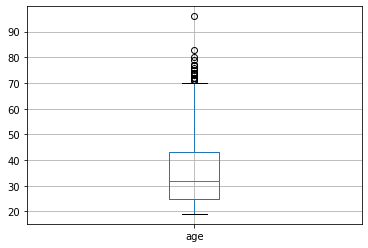

In [8]:
df_clean[["age"]].boxplot();

In [9]:
print(f"There are {df_clean[df_clean['age']>70].shape[0]} defendants who are older than 70 years")
print("Even though these cases are marked as outliers, they seem to be valid cases and thus should not be removed")

There are 22 defendants who are older than 70 years
Even though these cases are marked as outliers, they seem to be valid cases and thus should not be removed


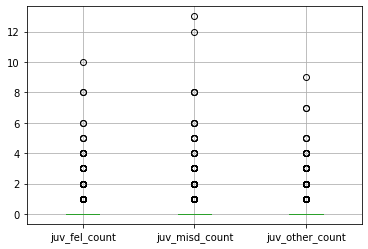

In [10]:
df_clean[['juv_fel_count', 'juv_misd_count', 'juv_other_count']].boxplot();

In [11]:
print(f"Defendants with >0 juv_fel_count: {df_clean[df_clean['juv_fel_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_fel_count']>0].shape[0]/df_clean.shape[0],2)}%")
print(f"Defendants with >0 juv_misd_count: {df_clean[df_clean['juv_misd_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_misd_count']>0].shape[0]/df_clean.shape[0],2)}%")
print(f"Defendants with >0 juv_other_count: {df_clean[df_clean['juv_other_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_other_count']>0].shape[0]/df_clean.shape[0],2)}%")

Defendants with >0 juv_fel_count: 164, 0.03%
Defendants with >0 juv_misd_count: 277, 0.05%
Defendants with >0 juv_other_count: 368, 0.07%


- The vast majority of defendants in this dataset has no criminal juvenile records. 
- Even though the numbers are relatively small, there is no indication that there was an error in creating the dataset
- These repeated juvenile offenders seem to be rare, but valid "outliers" and thus should not be removed!

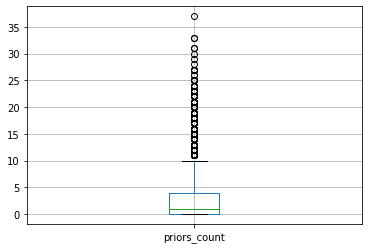

In [12]:
df_clean[['priors_count']].boxplot();

In [13]:
print(f"Defendants with >10 priors: {df_clean[df_clean['priors_count']>10].shape[0]}, \
{np.round(df_clean[df_clean['priors_count']>10].shape[0]/df_clean.shape[0],2)}%")

Defendants with >10 priors: 365, 0.07%


There are 365 defendants with more than 10 priors. Nevertheless these repeated offenders seem to be rare, but valid "outliers" and thus should not be removed!

# Feature Engineering: Create feature `c_charge_degree_detailed`

- The current charges of the ProPublica dataset are categorized as felonies or misdemeanors `c_charge_degreee``
- The `c_charge_desc` contains the description of the crime (e.g. murder, Grand theft ...)
- In Florida each crime is based on the severness categorised into different level/ classes of misdemeanors or felonies

In [14]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df_clean.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df_clean[df_clean["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df_clean[df_clean["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))

Unique charges in the dataset: 359
Unique charges for felonies: 266
Unique charges for misdemeanors: 126


- In order to reduce the variaty of charges we created a new feature to cluster each crime into the correct level
- The original dataset already contains the more detailed degree of crimes, but only for the recidivist crimes
- We first used these crimes and map them against the current charges 

In [15]:
# check unique values/ classes of charges 
df_clean.r_charge_degree.unique()

array([nan, '(F3)', '(M1)', '(F2)', '(M2)', '(MO3)', '(F1)', '(F6)',
       '(F7)', '(CO3)', '(F5)'], dtype=object)

In [16]:
# Create lookup table for c_charge_degree_detailed based on c_charge_desc
lookup_c_charge_degree = pd.merge(
    df_clean[["c_charge_desc"]], 
    df_clean[
        (df_clean["r_charge_degree"]!='(MO3)') & #filter out classes of felonies and misdemeanors who do not exist
        (df_clean["r_charge_degree"]!='(F6)') &
        (df_clean["r_charge_degree"]!='(F7)') &
        (df_clean["r_charge_degree"]!='(CO3)') & 
        (df_clean["r_charge_degree"]!='(F5)') &
        (df_clean["r_charge_degree"]!=np.nan)
        ][["r_charge_degree", "r_charge_desc"]], 
    left_on="c_charge_desc", 
    right_on="r_charge_desc")

In [17]:
#drop duplicated c_charge_desc so we end up with unique charges and degrees
lookup_c_charge_degree = lookup_c_charge_degree[["c_charge_desc", "r_charge_degree"]].drop_duplicates()
lookup_c_charge_degree.columns = ["c_charge_desc", "c_charge_degree_detailed"]

#reset index 
lookup_c_charge_degree = lookup_c_charge_degree.reset_index(drop=True)
lookup_c_charge_degree

,c_charge_desc,c_charge_degree_detailed
0,Felony Battery w/Prior Convict,(F3)
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
...,...,...
169,Deliver Cannabis 1000FTSch,(F2)
170,Sex Batt Faml/Cust Vict 12-17Y,(F1)
171,Possession Of Clonazepam,(F3)
172,Deliver Cocaine 1000FT School,(F1)


In [18]:
#Find charges which do have multiple charge_degrees
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
12,Susp Drivers Lic 1st Offense,(M2)
13,Susp Drivers Lic 1st Offense,(M1)
29,False Ownership Info/Pawn Item,(F3)
30,False Ownership Info/Pawn Item,(F2)
36,Petit Theft,(M2)
37,Petit Theft,(M1)


In [19]:
#Decide for one degree for each duplicate -> we keep the harder class degrees (based on online research)
rows_to_drop = [2, 4, 12, 13, 29, 36, 43, 53, 65, 88]

#drop rows based on index 
lookup_c_charge_degree = lookup_c_charge_degree.drop(index=rows_to_drop)

In [20]:
#check that there are no more duplicates 
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed


In [21]:
#set index to c_charge_desc and drop row with c_charge_desc = NaN
lookup_c_charge_degree.set_index("c_charge_desc", inplace=True)
lookup_c_charge_degree = lookup_c_charge_degree[lookup_c_charge_degree.index.notnull()]

#Remove parenthesis from the labels 
lookup_c_charge_degree["c_charge_degree_detailed"] = lookup_c_charge_degree.c_charge_degree_detailed.str.strip("( )")

In [22]:
#Use lookup table to label charges based on description
charges_to_label = df_clean.merge(lookup_c_charge_degree, how="left", left_on="c_charge_desc", right_index=True)

In [23]:
charges_to_label[charges_to_label["c_charge_degree_detailed"].notna()].shape

(4099, 17)

- 4099 of the 5304 cases could be labeled automatically based on the r_charge_degree 
- The remaining chases/charges need to be labeled manually

## Create list for charges which could not be matched automatically and need to be labeled manually

In [24]:
#Filter for rows which could not be labeled by the current lookup table (because they did not exist in r_charge_desc)
charges_to_label = charges_to_label[charges_to_label["c_charge_degree_detailed"].isnull()]

In [25]:
# Create list of unique charges which could not be labeled. These charges need to be labeled manually (online research)
charges_to_label_list = charges_to_label.groupby("c_charge_desc")[["id"]].count().sort_values(by="id", ascending=False)
charges_to_label_list["c_charge_degree_detailed"]=""
charges_to_label_list.columns = ['count', 'c_charge_degree_detailed']

charges_to_label_list

,count,c_charge_degree_detailed
c_charge_desc,,
arrest case no charge,684,
Felony Driving While Lic Suspd,73,
Susp Drivers Lic 1st Offense,45,
Aggravated Assault w/Firearm,20,
Poss Contr Subst W/o Prescript,15,
...,...,...
False Name By Person Arrest,1,
Falsely Impersonating Officer,1,
Grand Theft of a Fire Extinquisher,1,


There are 684 cases where the defendant wasn't pressed with charges. These cases will be encoded as `0` (less severe than M2 misdemeanors)

In [26]:
# Export to .csv file so the charges can be labeled manually (only has to be executed once)
# charges_to_label_list.to_csv("charges_to_label.csv")

## Import manually labeld .csv file and combine with `lookup_c_charge_degree` to create master lookup table

In [27]:
# import manually labeled data
labeled_charges_man = pd.read_csv("charges_labeled_man.csv", index_col=0).set_index("c_charge_desc")[["c_charge_degree_detailed"]]

In [28]:
#Create master lookup table by combining manually labeled data with automatically labeled data
lookup_c_charge_degree_master = pd.concat([lookup_c_charge_degree, labeled_charges_man], axis=0)

In [29]:
# Save master lookup table as .csv so it can be imported directly (only has to be executed once)
#lookup_c_charge_degree_master.to_csv("labeled_charges_master.csv")

## Map charge degree to all cases and store in new feature column `c_charge_degree_detailed`

In [30]:
# Load master lookup table
labeled_charges_master = pd.read_csv("labeled_charges_master.csv", index_col="c_charge_desc")

In [31]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df_clean = df_clean.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df_clean.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='c_charge_degree_detailed', ylabel='count'>

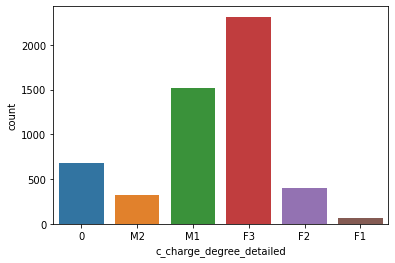

In [32]:
sns.countplot(x="c_charge_degree_detailed", data=df_clean, order=["0","M2", "M1", "F3", "F2", "F1"])

- More than 50% of charges in our dataset were labeled as M1 or F3 
- 684 cases are encoded as 0 (arrest case no charge)

In [33]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df_clean[df_clean.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed
114,243,39,25 - 45,Male,Caucasian,1,0,0,1,M,NaN,Low,4,NaN,NaN,0,NaN
2191,4521,27,25 - 45,Female,Caucasian,0,0,0,0,F,NaN,Medium,5,NaN,NaN,0,NaN
4031,8299,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,4,NaN,NaN,0,NaN
4202,8679,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,3,NaN,NaN,0,NaN
5183,10737,69,Greater than 45,Female,Caucasian,0,0,0,5,F,NaN,Low,3,NaN,NaN,0,NaN


In [34]:
index_nan_cases = df_clean[df_clean.c_charge_degree_detailed.isnull()].index

- There are still 5 cases which did not have a description of the current charges. 
- These 5 cases need to be imputed
- This requires the encoding of all categorical features first

# Data preprocessing

## Select relevant features and perform train_test_split

### Create Dataframe without `race`

In [35]:
#Select features for Classification model of general recidivism
# Select age or age_cat, exclude/ include race
columns_clas = ["age", "age_cat", "sex", #"race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas = df_clean[columns_clas].copy()

X = df_clas.drop(columns="two_year_recid")
y = df_clas["two_year_recid"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

### Create Dataframe with `race`

In [37]:
columns_clas_race = ["age", "age_cat", "sex", "race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas_race = df_clean[columns_clas_race].copy()

X_race = df_clas_race.drop(columns="two_year_recid")
y_race = df_clas_race["two_year_recid"]

In [38]:
X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(X_race,y_race, test_size=0.3)

## Create preprocessing pipeline

- `preproc_numerical` to impute and scale features
- `preproc_ordinal` to ordinaly encode `
- `preproc_nominal` to one hot encode the other ones (only relevant when race would be a feature)

### Preprocessing pipeline without `race`as feature

In [39]:
feat_ordinal_dict = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
    "sex": ["Male","Female"]
    }

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal = make_pipeline(
    encoder_ordinal,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['Less than 25', '25 - 45',
                                             'Greater than 45'],
                                            ['M', 'F'],
                                            ['0', 'M2', 'M1', 'F3', 'F2', 'F1'],
                                            ['Male', 'Female']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('knnimputer', KNNImputer(missing_values=-1, n_neighbors=25)),
                ('minmaxscaler', MinMaxScaler())])

In [40]:
# Define numerical feature once-for-all
#from sklearn.compose import make_column_selector
#feat_numerical = make_column_selector(dtype_include='number')

feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)
#feat_numerical = sorted(df_clas.select_dtypes(include=["int64", "float64"]).columns)


preproc_numerical = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
    MinMaxScaler()
)

In [41]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
#    (preproc_nominal, feat_nominal), (only needed when race a Feature)
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2',
                                                                              'M1',
                                                                              'F3',
                                                                              'F2',
                                                                              'F1'],
                                                                             ['Male',
                                                                              'Female']],
                                                                 dtype=<class 'numpy.int64'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed', 'sex'])])

In [42]:
#Test preproc pipeline
preproc.fit(df_clean)

column_nam = feat_numerical + feat_ordinal#+list(preproc.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))

test = pd.DataFrame(preproc.transform(df_clean), columns=column_nam)

test.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,sex
0,0.649351,0.0,0.0,0.000000,0.000000,1.0,1.0,0.6,0.0
1,0.194805,0.0,0.0,0.000000,0.000000,0.5,1.0,0.6,0.0
2,0.064935,0.0,0.0,0.111111,0.108108,0.0,1.0,0.6,0.0


In [43]:
# #Test knnImputing of missing values 

# test.loc[index_nan_cases]
# test["c_charge_degree_detailed"]= test.c_charge_degree_detailed.apply(np.ceil)
# test.loc[index_nan_cases]

### Preprocessing pipeline with `race`as feature

If race is included as a feature we have to create an additional columntransformer to OHE the `race`feature. 

In [44]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
# only relevant if race is a feature 
feat_nominal = sorted(list(set(X_race.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")#, drop="first")
)

In [45]:
preproc_race = make_column_transformer(
    (preproc_numerical, feat_numerical), #stays the same since race is a nominal feature
    (preproc_ordinal, feat_ordinal), #stays the same since race is a nominal feature
    (preproc_nominal, feat_nominal), 
    remainder="drop")

preproc_race

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2'...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed', 'sex']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['race'])])

In [46]:
#Test preproc race pipeline
preproc_race.fit(X_race)

column_nam_r = feat_numerical + feat_ordinal+list(preproc_race.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))

test = pd.DataFrame(preproc_race.transform(X_race), columns=column_nam_r)
test.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,sex,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
0,0.649351,0.0,0.0,0.000000,0.000000,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.194805,0.0,0.0,0.000000,0.000000,0.5,1.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.064935,0.0,0.0,0.111111,0.108108,0.0,1.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Balancing - *not started yet*

- As we already saw in the data exploration, the number of data points of the COMPAS dataset representing `two_years_recid`, `race`, `sex` is imbalanced
- This may pose a problem since ML algorithms learn by example and could therefore tend to predict under represented classes poorly

In [47]:
#Check balancing of y 
df_clean.two_year_recid.value_counts(normalize=True)

0    0.63405
1    0.36595
Name: two_year_recid, dtype: float64

In [48]:
#Check balancing of race
df_clean.race.value_counts(normalize=True)

African-American    0.505656
Caucasian           0.344834
Hispanic            0.084465
Other               0.058258
Asian               0.005090
Native American     0.001697
Name: race, dtype: float64

In [49]:
#Check balancing of sex
df_clean.sex.value_counts(normalize=True)

Male      0.808258
Female    0.191742
Name: sex, dtype: float64

### SMOTE

In [50]:
print("Number of unique cases in dataset:",df_clean.shape[0])

Number of unique cases in dataset: 5304


- Since our original dataset is relatively small, we decided against sampling down the majority class (Undersampling)
- We will therefore oversample the minority classes using the SMOTE algorithm. 
- SMOTE is an oversampling algorithm that generates new minority instances from existing minority instances based on linear combinations of existing points.
- We only use balancing techniques on the training set. We want to keep our test set as representative of real life as possible.

Check [imbalanced-learn](https://imbalanced-learn.org/)

In [51]:
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from collections import Counter

In [52]:
test_df = pd.concat([test, y], axis=1)

In [53]:
X_t = test_df.drop(columns=["two_year_recid"])
y_t = test_df.two_year_recid

In [54]:
X_t

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,sex,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
0,0.649351,0.0,0.0,0.000000,0.000000,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.194805,0.0,0.0,0.000000,0.000000,0.5,1.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.064935,0.0,0.0,0.111111,0.108108,0.0,1.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.324675,0.0,0.0,0.000000,0.000000,0.5,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.285714,0.0,0.0,0.000000,0.378378,0.5,1.0,0.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5299,0.012987,0.0,0.0,0.000000,0.000000,0.0,1.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5300,0.051948,0.0,0.0,0.000000,0.000000,0.0,1.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5301,0.051948,0.0,0.0,0.000000,0.000000,0.0,1.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5302,0.493506,0.0,0.0,0.000000,0.000000,1.0,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
sm = SMOTENC(categorical_features=[5,6,7,8])
X_res, y_res = sm.fit_resample(X_t, y_t)
print(f'Resampled dataset samples per class {Counter(y_res)}')

Resampled dataset samples per class Counter({0: 3363, 1: 3363})


In [56]:
smt = SMOTETomek(smote=sm)

In [57]:
X_res_t, y_res_t = smt.fit_resample(X_t, y_t)
print(f'Resampled dataset samples per class {Counter(y_res_t)}')

Resampled dataset samples per class Counter({0: 3157, 1: 3157})


In [58]:
X_res_t[["sex"]].value_counts()

sex
0.0    5246
1.0    1068
dtype: int64

In [59]:
# Open question: How do we balance different feature/ target combinations (african_american + recid, caucasian + recid ....)

# Baseline model - Logistic Regression

As a baseline model for the prediction of general recidivism we choose a "simple" Logistic Regression Classifier without hyperparameter tuning.

In [60]:
model = LogisticRegression()
pipe_log = make_pipeline(preproc, model)

In [162]:
pipe_log

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '25',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '45',
                                                                                               'Gr...
                                                                                               '45'],
                                                                                              ['M',
                                                                                               'F'],
                                                                                              ['0',
                                                                                               'M2',
                                                                                               'M1',
                                                                                               'F3',
                                                                                               'F2',
                                                                                               'F1'],
                                                                                              ['Male',
                                                                                               'Female']],
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age_cat', 'c_charge_degree',
                                                   'c_charge_degree_detailed',
                                                   'sex'])])),
                ('logisticregression', LogisticRegression())])

In [61]:
baseline_log_cv = cross_validate(pipe_log, X_train, y_train, cv=10, n_jobs=-1, scoring="neg_log_loss")

In [62]:
baseline_score = np.mean(baseline_log_cv["test_score"])
print("10 fold cross validated score of untuned Logistic regression model:", baseline_score)

10 fold cross validated score of untuned Logistic regression model: -0.5810814095710762


In [63]:
baseline_log = pipe_log.fit(X_train, y_train)

In [64]:
y_pred = baseline_log.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6062383707161947

In [65]:
confusion_matrix(y_test, y_pred)

array([[916,  86],
       [414, 176]])

In [66]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.69      0.91      0.79      1002
    is_recid       0.67      0.30      0.41       590

    accuracy                           0.69      1592
   macro avg       0.68      0.61      0.60      1592
weighted avg       0.68      0.69      0.65      1592



# Feature selection

- Some of the columns are different representations of the same data (eg. age and age_cat) and are therfore highly correlated
- Furthermore we want to remove features that, when in combination with all the others, do not really help predict our target

## Feature correlation

Use Pearson's correlation combined with a heatmap to check visually whether some **numerical** features almost entirely correlated with others and remove one of two features.
- High correlation = redundant information

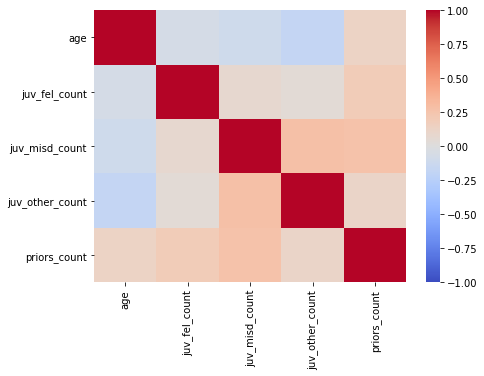

In [67]:
corr_num = X_train.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

In [68]:
corr_df = corr_num.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
13,juv_misd_count,juv_other_count,0.277315
17,juv_other_count,juv_misd_count,0.277315
22,priors_count,juv_misd_count,0.263386
14,juv_misd_count,priors_count,0.263386
9,juv_fel_count,priors_count,0.193254


---

For **ordinal features**, we can use Spearman's rank correlation instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarily than others.

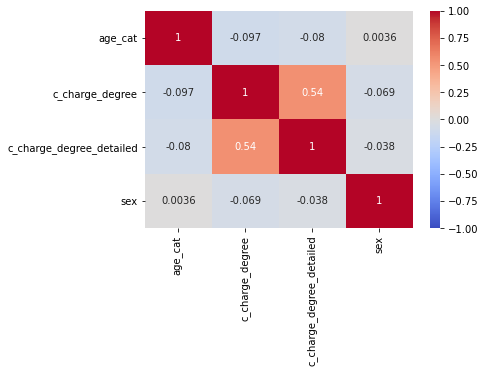

In [69]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]), columns=feat_ordinal)
sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1, annot=True);

- Using Spearman we see a high correlation between `c_charge_degree` and `c_charge_degree_detailed`
- This makes sense, since the `c_charge_degree_detailed` is our engineered feature which is a more granular classification of felonies and misdemeanors. We should therefore drop one of the features
- However, using Spearman only for the ordinally encoded features we can not assess the correlation between age and age_cat. This correlation assessment could only been performed after encoding.

---
- In order to assess the correlation between all features we use the transformed and encoded features. 
- We see the high correlation between `age_cat` and `age` and `c_charge_degree` and `c_charge_degree_detailed`

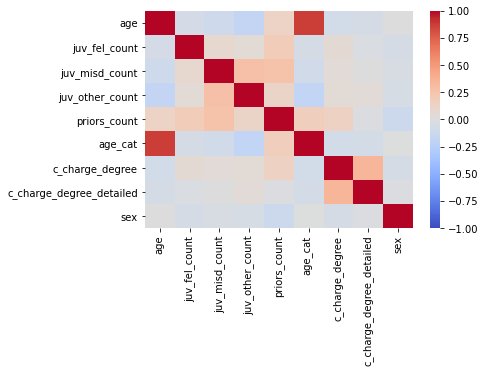

In [70]:
df_enc = pd.DataFrame(preproc.fit_transform(X_train), columns=feat_numerical+feat_ordinal)
sns.heatmap(df_enc.corr(), cmap='coolwarm',vmin=-1, vmax=1);

---

### Assess correlation on complete dataset (including `race` and `y`)

In [71]:
# Define numerical feature once-for-all for race pipeline
feat_numerical_y = sorted(df_clas.select_dtypes(include=["int64", "float64"]).columns)

In [72]:
#Create preproc pipeline with race and target y
preproc_ra_y = make_column_transformer(
    (preproc_numerical, feat_numerical_y), #stays the same since race is a nominal feature
    (preproc_ordinal, feat_ordinal), #stays the same since race is a nominal feature
    (preproc_nominal, feat_nominal), 
    remainder="drop")

preproc_ra_y

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count',
                                  'two_year_recid']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed', 'sex']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['race'])])

In [73]:
#Test preproc_ra_y pipeline
preproc_ra_y.fit(df_clean)

column_nam = feat_numerical_y + feat_ordinal+ list(preproc_ra_y.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))

df_enc_race = pd.DataFrame(preproc_ra_y.transform(df_clean), columns=column_nam)

df_enc_race.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,age_cat,c_charge_degree,c_charge_degree_detailed,sex,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
0,0.649351,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.194805,0.0,0.0,0.000000,0.000000,1.0,0.5,1.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.064935,0.0,0.0,0.111111,0.108108,1.0,0.0,1.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0


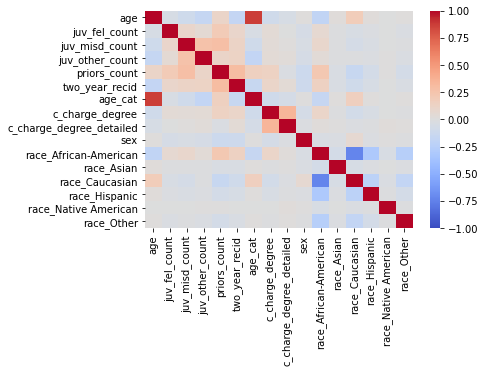

In [74]:
sns.heatmap(df_enc_race.corr(), cmap='coolwarm',vmin=-1, vmax=1);

## Forward Selection using `SequentialFeatureSelector` 

In [75]:
sfs_forward = SequentialFeatureSelector(LogisticRegression(), direction="forward")

In [76]:
pipe_sfs = make_pipeline(preproc, sfs_forward)

In [77]:
#pipe_sfs.fit(X_train, y_train)

#X.columns[pipe_sfs["sequentialfeatureselector"].get_support()]

In [78]:
# Create pipe with best parameters from baseline model
baseline = LogisticRegression()
pipe_sfs_log = make_pipeline(pipe_sfs, baseline)

In [79]:
#Grid Search 
param_grid =  {'pipeline__sequentialfeatureselector__n_features_to_select': np.arange(2,9)}

grid_sfs_log = GridSearchCV(pipe_sfs_log, param_grid, 
                          cv=10, n_jobs=-1, scoring="neg_log_loss")

grid_sfs_log.fit(X_train, y_train);
print(grid_sfs_log.best_params_)
grid_sfs_log.best_score_

{'pipeline__sequentialfeatureselector__n_features_to_select': 8}


-0.582409285802602

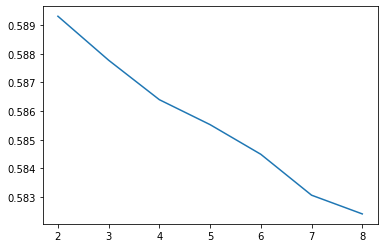

In [80]:
# Check results of gridSearch 
sns.lineplot(x=np.arange(2,9), y=-grid_sfs_log.cv_results_["mean_test_score"]);

In [81]:
y_pred = grid_sfs_log.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6120200277411278

In [82]:
confusion_matrix(y_test, y_pred)

array([[914,  88],
       [406, 184]])

In [83]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.69      0.91      0.79      1002
    is_recid       0.68      0.31      0.43       590

    accuracy                           0.69      1592
   macro avg       0.68      0.61      0.61      1592
weighted avg       0.69      0.69      0.65      1592



In [84]:
# Get selected features
sel_feat = grid_sfs_log.best_estimator_.named_steps["pipeline"]["sequentialfeatureselector"].get_support()

#See selected features
X.columns[sel_feat]

Index(['age', 'age_cat', 'sex', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree_detailed'],
      dtype='object')

Out of the 9 total features only 3 were selected using simple forward selection 

## Backward Selection using `SequentialFeatureSelector` 

In [85]:
sfs_backward = SequentialFeatureSelector(LogisticRegression(), direction="backward")

In [86]:
pipe_sfs_b = make_pipeline(preproc, sfs_backward)

In [87]:
pipe_sfs_log_b = make_pipeline(pipe_sfs_b, baseline)

In [88]:
#Grid Search 
param_grid =  {'pipeline__sequentialfeatureselector__n_features_to_select': np.arange(2,9)}

grid_sfs_log_b = GridSearchCV(pipe_sfs_log_b, param_grid, 
                          cv=10, n_jobs=-1, scoring="neg_log_loss")

grid_sfs_log_b.fit(X_train, y_train);
print(grid_sfs_log_b.best_params_)
grid_sfs_log_b.best_score_

{'pipeline__sequentialfeatureselector__n_features_to_select': 8}


-0.5830735104972309

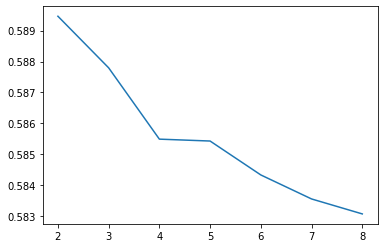

In [89]:
# Check results of gridSearch
sns.lineplot(x=np.arange(2,9), y=-grid_sfs_log_b.cv_results_["mean_test_score"]);

In [90]:
y_pred = grid_sfs_log_b.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6120200277411278

In [91]:
confusion_matrix(y_test, y_pred)

array([[914,  88],
       [406, 184]])

In [92]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.69      0.91      0.79      1002
    is_recid       0.68      0.31      0.43       590

    accuracy                           0.69      1592
   macro avg       0.68      0.61      0.61      1592
weighted avg       0.69      0.69      0.65      1592



In [93]:
# Get selected features
sel_feat = grid_sfs_log_b.best_estimator_.named_steps["pipeline"]["sequentialfeatureselector"].get_support()

#See selected features
X.columns[sel_feat]

Index(['age', 'age_cat', 'sex', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree_detailed'],
      dtype='object')

Using backward selection we get a quiet different result. From the 9 possible features 6 were selected

## Impurity reduction (MDI)

In [94]:
clf_forest = RandomForestClassifier()
pipe_forest = make_pipeline(preproc, clf_forest)
pipe_forest.fit(X_train, y_train);

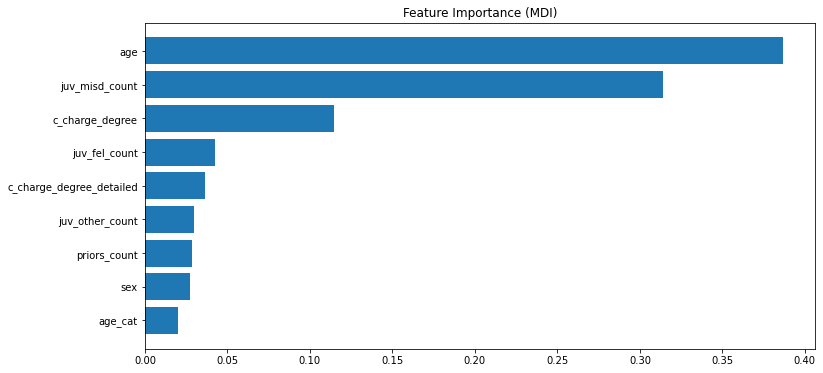

In [95]:
feature_importance = pipe_forest.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)");

## Feature permutation (MDA)

We want to remove features that, when in combination with all the others, do not really help predict our target.

To do so, we use feature `permutation_importance` importance in combination with an estimator! It trains one pipe per feature, so as to estimate which feature make our performance score *decrease* the most when shuffling it randomly. These would be our most important feature not to remove. 

In [96]:
## Create df instead of plot 

# permutation_score = permutation_importance(pipe_forest, X_train, y_train, n_repeats=10) # Perform Permutation

# importance_df = pd.DataFrame(np.vstack((X_train.columns,
#                                         permutation_score.importances_mean)).T) # Unstack results
# importance_df.columns=['feature','score decrease']

# importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

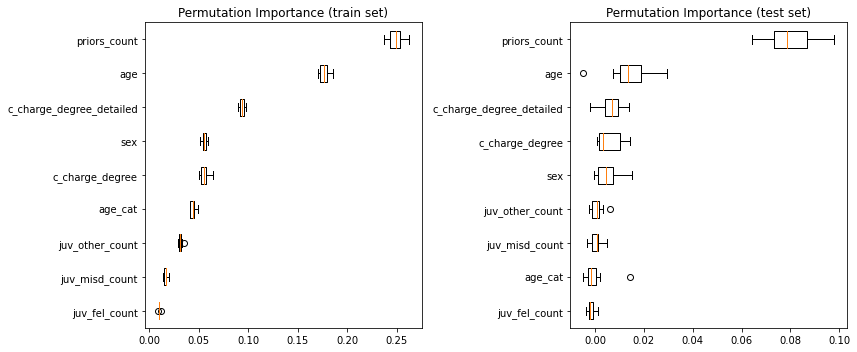

In [98]:
permutation_score = permutation_importance(pipe_forest, X_train, y_train, n_repeats=10) # Perform Permutation

fig = plt.figure(figsize=(12, 5))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score.importances_mean.argsort()
plt.boxplot(
    permutation_score.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (train set)")

#Plot MDA test set
plt.subplot(1, 2, 2)
permutation_score_test = permutation_importance(pipe_forest, X_test, y_test, n_repeats=10)
sorted_idx = permutation_score_test.importances_mean.argsort()
plt.boxplot(
    permutation_score_test.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_test.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")

fig.tight_layout()
plt.show()

- Using feature permutation, we see that the shuffling the feature `age` (which was also selected by the forward and backward feature selection) significantly leads to a decrease in score
- However, the feature with the highest score decrease `priors count` didn't get selected by the other feature selection techniques, whereas `juv_fel_count`and `juv_misd_count` which got selected do not lead to any score decrease!
- This behavior may be caused by the correlation between the features (e.g. `age` and `age_cat`, `juv_fel_count`, `juv_misd_count` and `priors_count` ...):<br> When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.
- We could decide to only keep the first five features, since we already know that `c_charge_degree_detailed` and `c_charge_degree` are highly correlated

### Test MDA on subset without `c_charge_degree` and `age_cat`

In [99]:
# Create new pipeline without features age_cat and c_charge_degree
feat_ordinal_dict_s = {
#    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
#    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
    "sex": ["Male","Female"]
    }

feat_ordinal_s = sorted(feat_ordinal_dict_s.keys()) # sort alphabetically
feat_ordinal_values_sorted_s = [feat_ordinal_dict_s[i] for i in feat_ordinal_s]

encoder_ordinal_s = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal_s = make_pipeline(
    encoder_ordinal_s,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal_s;

In [100]:
preproc_s = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal_s, feat_ordinal_s),
#    (preproc_nominal, feat_nominal), (only needed when race a Feature)
    remainder="drop")

pipe_forest_s = make_pipeline(preproc_s, RandomForestClassifier())
pipe_forest_s.fit(X_train, y_train);

In [101]:
permutation_score_s1 = permutation_importance(pipe_forest_s, X_train[feat_numerical + feat_ordinal_s], y_train, n_repeats=10) # Perform Permutation

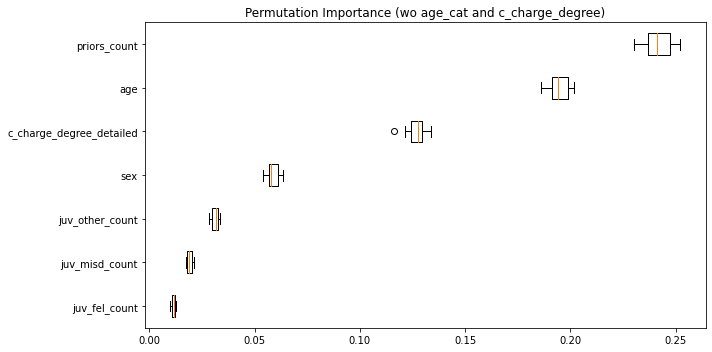

In [102]:
fig = plt.figure(figsize=(10, 5))

sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical+feat_ordinal_s)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

fig.tight_layout()
plt.show();

### Test MDA on subset without `c_charge_degree_detailed` and `age`

In [103]:
# Create new pipeline without features c_charge_degree_detailed and age
feat_ordinal_dict_s2 = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    "c_charge_degree": ["M", "F"],
#    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
    "sex": ["Male","Female"]
    }

feat_ordinal_s2 = sorted(feat_ordinal_dict_s2.keys()) # sort alphabetically
feat_ordinal_values_sorted_s2 = [feat_ordinal_dict_s2[i] for i in feat_ordinal_s2]

encoder_ordinal_s2 = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s2,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal_s2 = make_pipeline(
    encoder_ordinal_s2,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal_s2;

In [104]:
# Define numerical feature once-for-all
feat_numerical_s2 = sorted(X.select_dtypes(include=["int64", "float64"]).columns)
feat_numerical_s2.remove("age") #Remove age from list of numerical features

preproc_numerical_s2 = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
    MinMaxScaler()
)

In [105]:
preproc_s2 = make_column_transformer(
    (preproc_numerical_s2, feat_numerical_s2),
    (preproc_ordinal_s2, feat_ordinal_s2),
#    (preproc_nominal, feat_nominal), (only needed when race a Feature)
    remainder="drop")

pipe_forest_s2 = make_pipeline(preproc_s2, RandomForestClassifier())
pipe_forest_s2.fit(X_train, y_train);

In [106]:
permutation_score_s2 = permutation_importance(pipe_forest_s2, X_train[feat_numerical_s2 + feat_ordinal_s2], y_train, n_repeats=10) # Perform Permutation

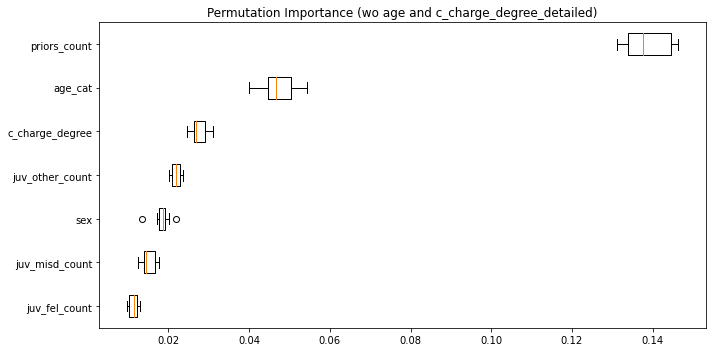

In [107]:
fig = plt.figure(figsize=(10, 5))

sorted_idx = permutation_score_s2.importances_mean.argsort()
plt.boxplot(
    permutation_score_s2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical_s2 + feat_ordinal_s2)[sorted_idx],
)
plt.title("Permutation Importance (wo age and c_charge_degree_detailed)")

fig.tight_layout()
plt.show();

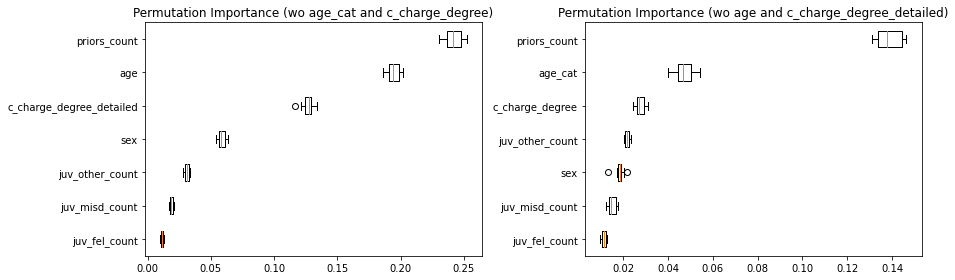

In [108]:
# Both plots side by side
fig = plt.figure(figsize=(13,4))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical+feat_ordinal_s)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

plt.subplot(1, 2, 2)
sorted_idx = permutation_score_s2.importances_mean.argsort()
plt.boxplot(
    permutation_score_s2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical_s2 + feat_ordinal_s2)[sorted_idx],
)
plt.title("Permutation Importance (wo age and c_charge_degree_detailed)")

fig.tight_layout()
plt.show();

- We see more important features in the subset with `age` and `c_charge_degree_detailed`
- Removing `age_cat` and `c_charge_degree` also led to an increase of the overall importance for the other features

# Model iteration

## Logistic Regression

### Tuned Logistic regression with `elasticnet` solver

In [109]:
model = LogisticRegression()
pipe_log = make_pipeline(preproc, model)

In [110]:
#Grid Search
param_grid =  {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)
              }

search_log = GridSearchCV(pipe_log, param_grid, 
                          cv=10, n_jobs=-1, scoring="neg_log_loss")

search_log.fit(X_train, y_train);
print(search_log.best_params_)
search_log.best_score_

{'logisticregression__C': 1.0, 'logisticregression__l1_ratio': 1.0, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}


-0.5808650931758165

In [111]:
y_pred = search_log.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6128674853682465

In [112]:
confusion_matrix(y_test, y_pred)

array([[914,  88],
       [405, 185]])

In [113]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.69      0.91      0.79      1002
    is_recid       0.68      0.31      0.43       590

    accuracy                           0.69      1592
   macro avg       0.69      0.61      0.61      1592
weighted avg       0.69      0.69      0.65      1592



### Tuned Logistic regression with different `l2` solvers

The `l2` solvers are calculated separately to the `elasticnet`, because these solvers do not work with `l1`

In [114]:
#Grid Search
param_grid =  {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,100),
              }

search_log_2 = GridSearchCV(pipe_log, param_grid, 
                          cv=10, n_jobs=-1, scoring="neg_log_loss")

search_log_2.fit(X_train, y_train);
print(search_log_2.best_params_)
search_log_2.best_score_

{'logisticregression__C': 2.618181818181818, 'logisticregression__solver': 'lbfgs'}


-0.580879988309366

In [115]:
y_pred = search_log_2.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6084796508677559

In [116]:
confusion_matrix(y_test, y_pred)

array([[912,  90],
       [409, 181]])

In [117]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.69      0.91      0.79      1002
    is_recid       0.67      0.31      0.42       590

    accuracy                           0.69      1592
   macro avg       0.68      0.61      0.60      1592
weighted avg       0.68      0.69      0.65      1592



### Best tuned model with feature selection

## Tree models

### Single untuned tree model

In [118]:
tree_model = DecisionTreeClassifier(max_depth=3)
pipe_tree = make_pipeline(preproc, tree_model)
score_tree = cross_val_score(pipe_tree, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", score_tree.std())
score_tree.mean()

Standard deviation across different folds: 0.015584137414377485


-0.5843005181238476

In [119]:
tree_base = pipe_tree.fit(X_train, y_train)

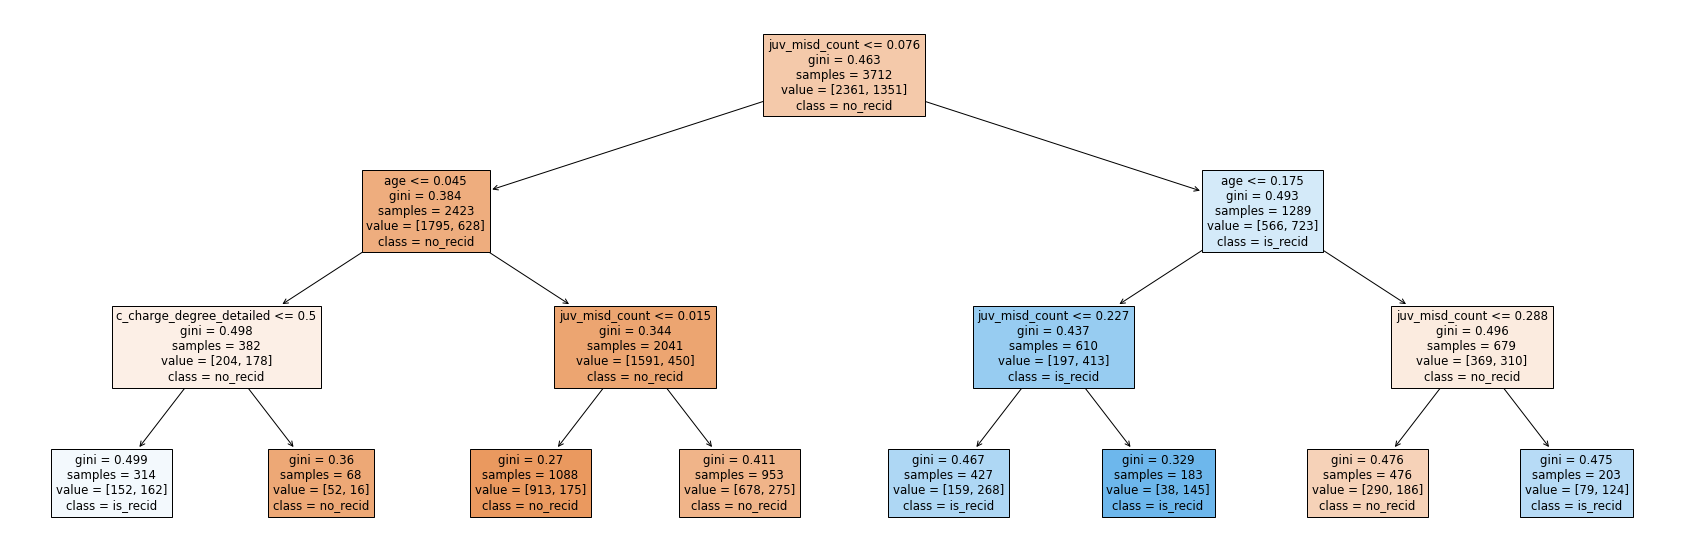

In [120]:
plt.figure(figsize=(30,10))
plot_tree(tree_base["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

In [121]:
y_pred = tree_base.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6578825400047363

In [122]:
confusion_matrix(y_test, y_pred)

array([[814, 188],
       [293, 297]])

In [123]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.74      0.81      0.77      1002
    is_recid       0.61      0.50      0.55       590

    accuracy                           0.70      1592
   macro avg       0.67      0.66      0.66      1592
weighted avg       0.69      0.70      0.69      1592



### Single hyperparameter-tuned tree

In [124]:
tree = DecisionTreeClassifier()
pipe_tree = make_pipeline(preproc, tree)

In [125]:
#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,6),
               'decisiontreeclassifier__min_samples_split': np.arange(2,30,10),
               'decisiontreeclassifier__min_samples_leaf': np.arange(0.01,0.3, 0.1),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"],
               'decisiontreeclassifier__min_impurity_decrease': np.arange(0.0,0.5,0.1)
               }

tree_tuned_cv = GridSearchCV(pipe_tree, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring="neg_log_loss")

tree_tuned_cv.fit(X_train, y_train);
print(tree_tuned_cv.best_params_)
tree_tuned_cv.best_score_

{'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_impurity_decrease': 0.0, 'decisiontreeclassifier__min_samples_leaf': 0.01, 'decisiontreeclassifier__min_samples_split': 2}


-0.5834731161924224

In [126]:
y_pred = tree_tuned_cv.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6440474982238912

In [127]:
confusion_matrix(y_test, y_pred)

array([[861, 141],
       [337, 253]])

In [128]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.72      0.86      0.78      1002
    is_recid       0.64      0.43      0.51       590

    accuracy                           0.70      1592
   macro avg       0.68      0.64      0.65      1592
weighted avg       0.69      0.70      0.68      1592



### Single tuned tree with forward feature selection

In [129]:
best_sfs_forward = SequentialFeatureSelector(LogisticRegression(), direction="forward", n_features_to_select=3)

In [130]:
pipe_sfs_forward = make_pipeline(preproc, best_sfs_forward)

In [131]:
# Create pipe with best parameters from tuned tree model
best_tree = DecisionTreeClassifier(max_depth=5, max_features=None, min_impurity_decrease=0.0, min_samples_leaf=0.01, min_samples_split=2)
pipe_sfs_tree = make_pipeline(pipe_sfs_forward, best_tree)

In [132]:
score_sfs_tree = cross_val_score(pipe_sfs_tree, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", score_sfs_tree.std())
score_sfs_tree.mean()

Standard deviation across different folds: 0.017979816934700105


-0.5823804292257109

In [133]:
pipe_sfs_tree.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age',
                                                                    'juv_fel_count',
                                                                    'juv_misd_count',
                                                                    'juv_other_count',
                                                                    'priors_count']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['Les...
                                                                                   ('knnimputer',
                                                                                    KNNImputer(missing_values=-1,
                                                                                               n_neighbors=25)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_cat',
                                                                    'c_charge_degree',
                                                                    'c_charge_degree_detailed',
                                                                    'sex'])])),
                                 ('sequentialfeatureselector',
                                  SequentialFeatureSelector(estimator=LogisticRegression(),
                                                            n_features_to_select=3))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01))])

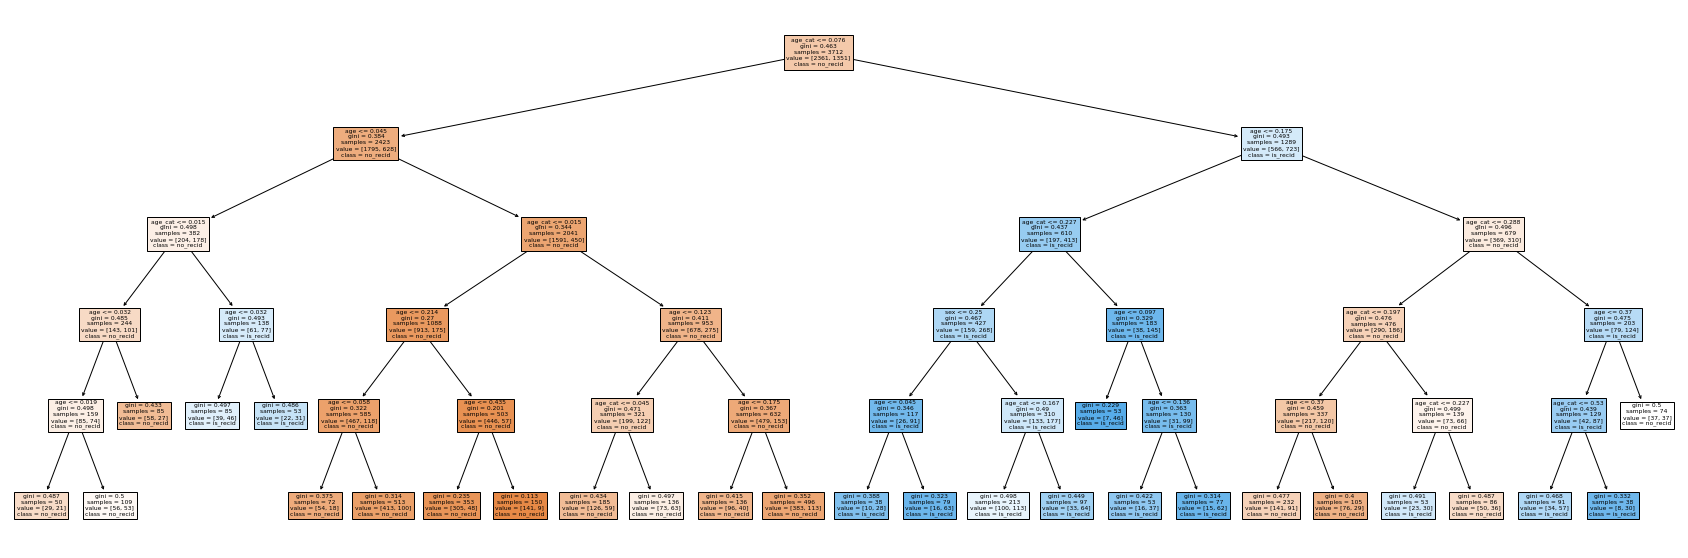

In [134]:
plt.figure(figsize=(30,10))
plot_tree(pipe_sfs_tree["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

In [135]:
y_pred = pipe_sfs_tree.predict(X_test)

roc_auc_score(y_test, y_pred)

0.639001657701546

In [136]:
confusion_matrix(y_test, y_pred)

array([[839, 163],
       [330, 260]])

In [137]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.72      0.84      0.77      1002
    is_recid       0.61      0.44      0.51       590

    accuracy                           0.69      1592
   macro avg       0.67      0.64      0.64      1592
weighted avg       0.68      0.69      0.68      1592



### Single tuned tree with backward feature selection

In [138]:
best_sfs_backward = SequentialFeatureSelector(LogisticRegression(), direction="backward", n_features_to_select=6)

In [139]:
pipe_sfs_backward = make_pipeline(preproc, best_sfs_backward)

In [140]:
# Create pipe with best parameters from tuned tree model
best_tree = DecisionTreeClassifier(max_depth=5, max_features=None, min_impurity_decrease=0.0, min_samples_leaf=0.01, min_samples_split=2)
pipe_sfs_tree_back = make_pipeline(pipe_sfs_backward, best_tree)

In [141]:
score_sfs_tree_back = cross_val_score(pipe_sfs_tree_back, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", score_sfs_tree_back.std())
score_sfs_tree_back.mean()

Standard deviation across different folds: 0.0232352510254796


-0.5850262519306104

In [142]:
pipe_sfs_tree_back.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age',
                                                                    'juv_fel_count',
                                                                    'juv_misd_count',
                                                                    'juv_other_count',
                                                                    'priors_count']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['Les...
                                                                                    KNNImputer(missing_values=-1,
                                                                                               n_neighbors=25)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_cat',
                                                                    'c_charge_degree',
                                                                    'c_charge_degree_detailed',
                                                                    'sex'])])),
                                 ('sequentialfeatureselector',
                                  SequentialFeatureSelector(direction='backward',
                                                            estimator=LogisticRegression(),
                                                            n_features_to_select=6))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01))])

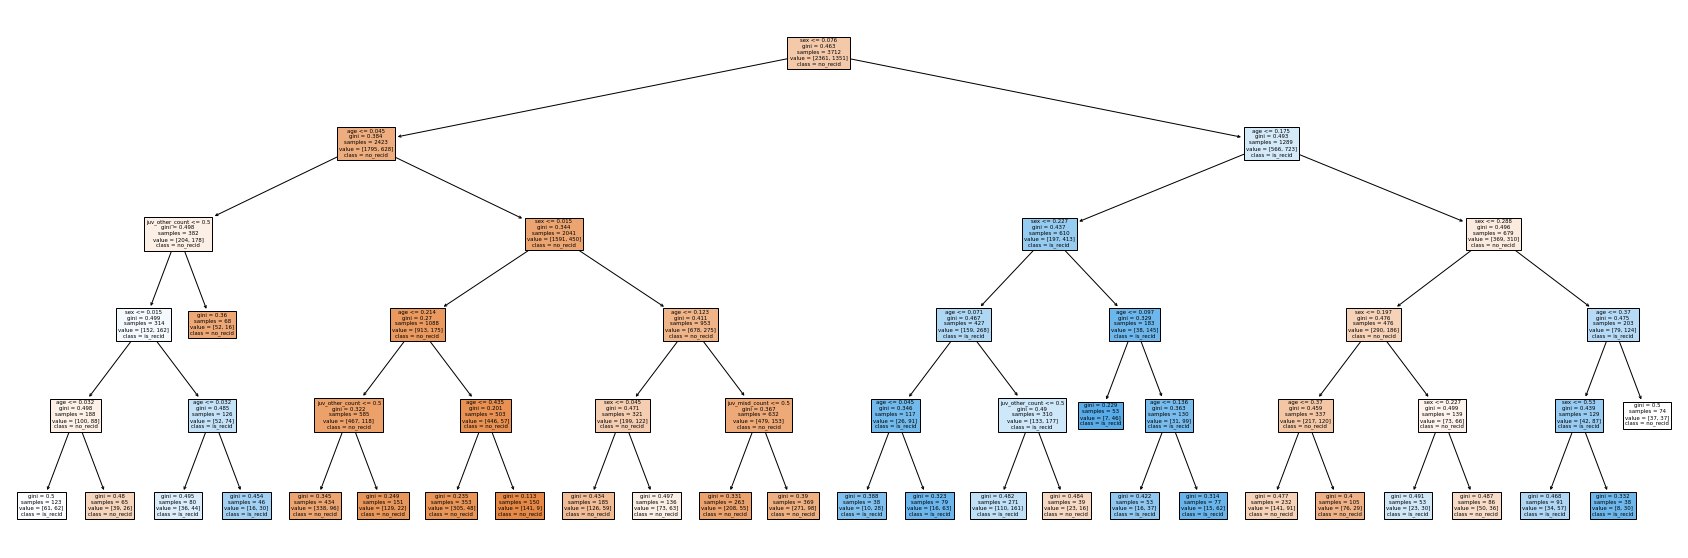

In [143]:
plt.figure(figsize=(30,10))
plot_tree(pipe_sfs_tree_back["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

In [144]:
y_pred = pipe_sfs_tree_back.predict(X_test)

roc_auc_score(y_test, y_pred)

0.640997665685578

In [145]:
confusion_matrix(y_test, y_pred)

array([[843, 159],
       [330, 260]])

In [146]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.72      0.84      0.78      1002
    is_recid       0.62      0.44      0.52       590

    accuracy                           0.69      1592
   macro avg       0.67      0.64      0.65      1592
weighted avg       0.68      0.69      0.68      1592



### Bagged tuned tree

In [147]:
bagged_tree = BaggingClassifier(base_estimator=best_tree, n_estimators=500)
pipe_tree_bagged = make_pipeline(preproc, bagged_tree)

In [148]:
score_sfs_bagged_tree = cross_val_score(pipe_tree_bagged, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", score_sfs_bagged_tree.std())
score_sfs_bagged_tree.mean()

Standard deviation across different folds: 0.01925809969364286


-0.572409363439852

In [149]:
pipe_tree_bagged.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '25',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '45',
                                                                                               'Gr...
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age_cat', 'c_charge_degree',
                                                   'c_charge_degree_detailed',
                                                   'sex'])])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                         min_samples_leaf=0.01),
                                   n_estimators=500))])

In [150]:
y_pred = pipe_tree_bagged.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6487837883554924

In [151]:
confusion_matrix(y_test, y_pred)

array([[862, 140],
       [332, 258]])

In [152]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.72      0.86      0.79      1002
    is_recid       0.65      0.44      0.52       590

    accuracy                           0.70      1592
   macro avg       0.69      0.65      0.65      1592
weighted avg       0.69      0.70      0.69      1592



### Bagged tuned tree with forward feature selection

In [153]:
bagged_tree = BaggingClassifier(base_estimator=best_tree, n_estimators=500)
pipe_tree_bagged_for = make_pipeline(pipe_sfs_forward, bagged_tree)

In [154]:
score_sfs_bagged_tree_for = cross_val_score(pipe_tree_bagged, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", score_sfs_bagged_tree_for.std())
score_sfs_bagged_tree_for.mean()

Standard deviation across different folds: 0.01919213258438722


-0.5726453977108731

In [155]:
pipe_tree_bagged_for.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age',
                                                                    'juv_fel_count',
                                                                    'juv_misd_count',
                                                                    'juv_other_count',
                                                                    'priors_count']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['Les...
                                                                                               n_neighbors=25)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_cat',
                                                                    'c_charge_degree',
                                                                    'c_charge_degree_detailed',
                                                                    'sex'])])),
                                 ('sequentialfeatureselector',
                                  SequentialFeatureSelector(estimator=LogisticRegression(),
                                                            n_features_to_select=3))])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                         min_samples_leaf=0.01),
                                   n_estimators=500))])

In [156]:
y_pred = pipe_tree_bagged_for.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6453855001860686

In [157]:
confusion_matrix(y_test, y_pred)

array([[845, 157],
       [326, 264]])

In [158]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.72      0.84      0.78      1002
    is_recid       0.63      0.45      0.52       590

    accuracy                           0.70      1592
   macro avg       0.67      0.65      0.65      1592
weighted avg       0.69      0.70      0.68      1592

